In [1]:
# Imports
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
# Connect to database
conn = sqlite3.connect('../data.db')
c = conn.cursor()

In [4]:
# Hypothesis Test 1:
# Null: 
# The number of visitors to a park is not a correlated with the number of animal species found in that park.

# Alternative: 
# The number of visitors to a park is positively correlated with the number of animal species found in that park.

# Query for number of unique animals by park and visitors by park
# Filter out outlier GRSM
query_1 = """
    SELECT COUNT(Park_Code) as num_species, Visitors
    FROM final
    WHERE Park_Code != 'GRSM' 
    GROUP BY Park_Code
    ORDER BY num_species DESC;
"""
q1_results = pd.read_sql_query(query_1, conn)
num_species = q1_results['num_species']
visitors = q1_results['Visitors']

# Statistical test for positive correlation
corr, p_value = stats.pearsonr(num_species, visitors)
print(f"Correlation: {corr}")
print(f"p_value:     {p_value}")
if p_value < 0.05: 
    print("Reject Null, Accept Alternative")
    print("The number of visitors to a park is positively correlated with the number of animal species found in that park!")
else:
    print("Fail to reject Null, Reject Alternative")
    print("The number of visitors to a park is not correlated with the number of animal species found in that park.")


Correlation: 0.2612795433608859
p_value:     0.05879027186447086
Fail to reject Null, Reject Alternative
The number of visitors to a park is not correlated with the number of animal species found in that park.


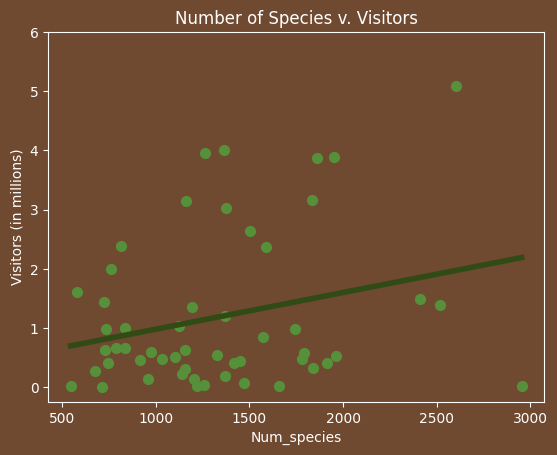

In [5]:
# Visualize above data in a scatter plot with line of best fit.
fig, ax = plt.subplots()
ax.scatter(num_species, visitors, color='#56903a', s=50)
m, b = np.polyfit(num_species, visitors, 1)
ax.plot(num_species, m * num_species + b, color='#304c14', linewidth=4)

# Customize to fit the theme.
ax.set_facecolor('#6f4930')
fig.set_facecolor('#6f4930')
ax.tick_params(axis='x', colors='white')
ax.set_yticks([0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000], [0, 1, 2, 3, 4, 5, 6])
ax.tick_params(axis='y', colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
plt.xlabel("Num_species", color='white')
plt.ylabel("Visitors (in millions)", color='white')
plt.title("Number of Species v. Visitors", color='white')
plt.show()

In [7]:
# Hypothesis Test 2:
# Null:
# Fish species are equally likely to be found in parks in coastal and non-coastal states.

# Alternative:
# Fish species are more likely to be found in parks in coastal states.

# Query that gives if each animal is or is not a fish and whether or not it is in a coastal state
# We account for the parks in multiple states by calling them non-coastal as the few that are multi
# state parks lie far inland.
query_2 ="""
    SELECT 
        CASE WHEN State IN 
            ('AK', 'AL', 'CA', 'CT', 'DE', 'FL', 'GA', 'HI',
             'LA', 'MA', 'MD', 'ME', 'MS', 'NC', 'NH', 'NJ', 
             'NY', 'OR', 'RI', 'SC', 'TX', 'VA', 'WA')
            THEN 'Coastal'
            ELSE 'Non-Coastal'
        END AS Coastality,
        CASE WHEN Category = 'Fish' THEN 'True' ELSE 'False'
        END AS Is_Fish
    FROM final
"""
q2_results = pd.read_sql_query(query_2, conn)
crosstab = pd.crosstab(q2_results['Coastality'], q2_results['Is_Fish'])
tstats, p_value, _, _ = stats.chi2_contingency(crosstab)

print(f"t_stats: {tstats}")
print(f"p_value: {p_value}")
if p_value < 0.05: 
    print("Reject Null, Accept Alternative")
    print("Fish species are more likely to be found in parks in coastal states!")
else:
    print("Fail to reject Null, Reject Alternative")
    print("Fish species are equally likely to be found in parks in coastal and non-coastal states.")


t_stats: 1026.9310720928302
p_value: 2.5147717972336433e-225
Reject Null, Accept Alternative
Fish species are more likely to be found in parks in coastal states!


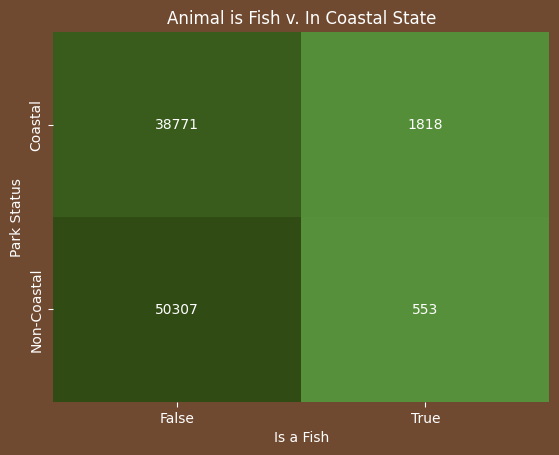

In [8]:
# Visualize above data in a heatmap.
fig, ax = plt.subplots()

colors = [(86/255, 144/255, 58/255), (48/255, 76/255, 20/255)] # black to #304c14 (National Park Service green)

# Create the custom colormap using LinearSegmentedColormap
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)

# Create a heatmap.
sns.heatmap(crosstab, annot=True, cmap=cmap, fmt='g', ax=ax, color='white', cbar=False, annot_kws={'color': 'white'})

# Customize the graph to fit the theme.
ax.set_title('Animal is Fish v. In Coastal State', color='white')
ax.set_xlabel('Is a Fish', color='white')
ax.set_ylabel('Park Status', color='white')
ax.set_facecolor('#6f4930')
fig.set_facecolor('#6f4930')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})

plt.show()

In [9]:
# Hypothesis Test 3:

# Null:
# Parks in the southern and northern half of the US have similar numbers of bird species per park.

# Alternative:
# Parks in the northern half of the US have more bird species per park than the southern half.

# Note, we use 39°50′N as the dividing latitude as it is considered the geographical center 
# of the continental US and this leaves Alaska in the north and Hawaii in the south without
# skewing our data within the continental US.
query_north ="""
    SELECT Park_Name, COUNT(Park_Code) as num_bird_species
    FROM final
    WHERE Category = 'Bird' AND Latitude > 39.50
    GROUP BY Park_Code
    ORDER BY num_bird_species DESC;
"""
query_south ="""
    SELECT Park_Name, COUNT(Park_Code) as num_bird_species
    FROM final
    WHERE Category = 'Bird' AND Latitude < 39.50
    GROUP BY Park_Code
    ORDER BY num_bird_species DESC;
"""
north_results = pd.read_sql_query(query_north, conn)
south_results = pd.read_sql_query(query_south, conn)

# Statistical test for positive correlation
t_stats, p_value = stats.ttest_ind(south_results['num_bird_species'], north_results['num_bird_species'])
print(f"t_stats: {t_stats}")
print(f"p_value: {p_value}")
if p_value < 0.05:
    print("Reject Null, Accept Alternative")
    print("Parks in the northern half of the US have more bird species per park than the southern half.")
else:
    print("Fail to reject Null, Reject Alternative")
    print("Parks in the southern and northern half of the US have similar numbers of bird species per park.")




t_stats: 1.2097637315781047
p_value: 0.2318406912027592
Fail to reject Null, Reject Alternative
Parks in the southern and northern half of the US have similar numbers of bird species per park.


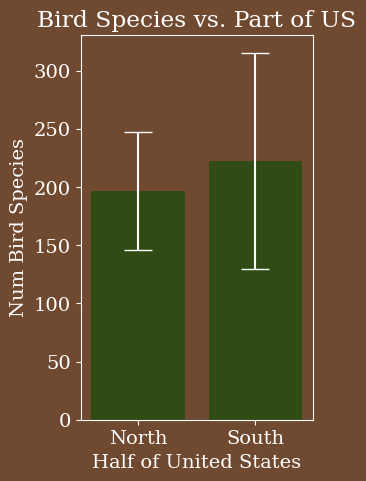

In [11]:
# Visualize above results in a bar chart.

# Get means and standard deviations.
north_mean = north_results['num_bird_species'].mean()
north_std = north_results['num_bird_species'].std()
south_mean = south_results['num_bird_species'].mean()
south_std = south_results['num_bird_species'].std()

# Plot data on a bar chart and customize to fit theme.
fig, ax = plt.subplots(figsize=(3,5))
ax.bar(['North', 'South'], [north_mean, south_mean], yerr=[north_std, south_std], capsize=10, color='#304c14', error_kw=dict(ecolor='white'))
ax.set_xlabel('Half of United States', color='white')
ax.set_ylabel('Num Bird Species', color='white')
ax.set_title('Bird Species vs. Part of US', color='white')
ax.set_facecolor('#6f4930')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
fig.set_facecolor('#6f4930')
plt.show()